In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# GPU 수동 할당
gpus = tf.config.experimental.list_physical_devices('GPU')

# GPU 수동 할당
# 0번 GPU 20000mb 사용
tf.config.experimental.set_virtual_device_configuration(gpus[0],
[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20000)])

try:
    with tf.device('/device:GPU:0'):

except RuntimeError as e:
    print(e)

In [3]:
model = tf.keras.models.load_model("./RUL/KHS/GRU_Att.h5")

In [4]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 10, 32)       3360        input_3[0][0]                    
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 32, 10)       0           gru_2[0][0]                      
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32, 10)       110         permute_2[0][0]                  
____________________________________________________________________________________________

In [17]:
# 데이터 불러오기
data0 = pd.read_csv("./RUL/Data/Gear/x0_gear.csv")
#data4 = pd.read_csv("D:/programming/Python/Inhatc Jupyter Server/RUL/Data/Gear/x4_gear.csv")

In [3]:
# 데이터를 넘파이 배열로 변환
data0_np = np.array(data0.values, np.float32())
data4_np = np.array(data4.values, np.float32())

In [18]:
# 일정 간격으로 평균을 나누어 계산
data_mean00 = []
data_mean44 = []
mean_step = 1
for i in range(24000//mean_step):
    data_mean00.append(np.mean(data0_np[i*mean_step:(i+1)*mean_step, 1]))
for j in range(24000//mean_step):
    data_mean44.append(np.mean(data4_np[j*mean_step:(j+1)*mean_step, 1]))

In [27]:
# 데이터 정규화
data_set = data_mean00# + data_mean44
data_set = np.array(data_set, np.float32)
data_set = data_set.reshape((24000, -1))
data_set = MinMaxScaler().fit_transform(data_set)

In [7]:
# 학습 데이터 만들기 - HI그래프 예측
def create_sequence(data, timestep, pred, input_dim):
    # 빈 리스트 선언
    X_data, y_data = [], []

    # 반복문을 통해 데이터를 저장
    # timestep 개수만큼 input_dim의 간격으로 리스트에 저장
    for i in range(len(data)-timestep-pred+1):
        temp = []
        for j in range(i, i+timestep, input_dim):
            temp.append([data[j]])
        X_data.append(temp)

        # 예측값 저장
        y_data.append(data[i+timestep:i+timestep+pred])
    return X_data, y_data

In [36]:
# 타임스텝 , 출력갯수, 속성 수  정의 후 시퀸스와 예측값 저장
timestep = 10
pred = 1
dim = 1
X_data, y_data = create_sequence(np.ravel(data_set, order="C"), timestep, pred, dim)

In [9]:
# 학습데이터와 테스트 데이터로 구분
def train_test_split(X_data, y_data, test_size):
    X_train = X_data[0:int(len(X_data)*(1-test_size))]
    X_test = X_data[int(len(X_data)*(1-test_size)):]
    y_train = y_data[0:int(len(y_data)*(1-test_size))]
    y_test = y_data[int(len(y_data)*(1-test_size)):]
    return X_train, X_test, y_train, y_test

In [75]:
# 넘파이 배열로 변환 및 데이터 저장
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 0.9)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [11]:
# 어텐션 메커니즘 모델
def attention_3d_block(inputs):
    
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    
    a = tf.keras.layers.Permute((2, 1))(inputs) # same transpose
    #a = tf.keras.layers.Reshape((input_dim, TIME_STEPS))(a) 
    # this line is not useful. It's just to know which dimension is what.
    a = tf.keras.layers.Dense(timestep, activation='softmax')(a)
    
    a_probs = tf.keras.layers.Permute((2, 1), name='attention_vec')(a)
    
    output_attention_mul  = tf.keras.layers.multiply([inputs, a_probs])
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

In [12]:
#  어텐션 GRU 모델 설계
def model_attention_applied_after_gru():
    # GRU 구문
    inputs        = tf.keras.Input(shape=(timestep, dim,))
    gru_units    = 32    
    gru_out      = tf.keras.layers.GRU(gru_units, return_sequences=True)(inputs)
    
    # 어텐션 메커니즘 구문
    attention_mul = attention_3d_block(gru_out)
    attention_mul = tf.keras.layers.Flatten()(attention_mul)
    
    # 시그모이드 출력
    output        = tf.keras.layers.Dense(1, activation='sigmoid')(attention_mul)    
    model         = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [31]:
# 모델 저장
modelman = model_attention_applied_after_gru()
modelman.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
# 모델 학습

modelman.fit([X_train], y_train, epochs=100, batch_size=128, validation_split=0.005)

layer_outputs    = [layer.output for layer in modelman.layers if layer.name == 'attention_vec']
activation_model = tf.keras.models.Model(inputs=modelman.input, outputs=layer_outputs)

Train on 2386 samples, validate on 12 samples
Epoch 1/100
2386/2386 [==============================] - 0s 57us/sample - loss: 0.5512 - accuracy: 0.0000e+00 - val_loss: 0.5910 - val_accuracy: 0.0000e+00
Epoch 2/100
2386/2386 [==============================] - 0s 59us/sample - loss: 0.5506 - accuracy: 0.0000e+00 - val_loss: 0.5904 - val_accuracy: 0.0000e+00
Epoch 3/100
2386/2386 [==============================] - 0s 58us/sample - loss: 0.5501 - accuracy: 0.0000e+00 - val_loss: 0.5900 - val_accuracy: 0.0000e+00
Epoch 4/100
2386/2386 [==============================] - 0s 57us/sample - loss: 0.5496 - accuracy: 0.0000e+00 - val_loss: 0.5896 - val_accuracy: 0.0000e+00
Epoch 5/100
2386/2386 [==============================] - 0s 57us/sample - loss: 0.5493 - accuracy: 0.0000e+00 - val_loss: 0.5900 - val_accuracy: 0.0000e+00
Epoch 6/100
2386/2386 [==============================] - 0s 56us/sample - loss: 0.5490 - accuracy: 0.0000e+00 - val_loss: 0.5895 - val_accuracy: 0.0000e+00
Epoch 7/100
2386/2

In [77]:
# 예측 데이터 저장
y_hat = modelman.predict(X_test)

In [83]:
# 모델 저장
modelman.save("GRU_Att.h5")

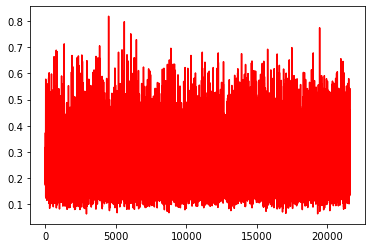

In [79]:
# 그래프를 통한 각 결과 비교
#plt.axis([0, 50, 0, 1])
plt.plot(y_hat, "r-")
plt.plot(y_test, "b-")
plt.show()

In [84]:
# 모델을 이용하여 예측 데이터 부풀리기
list_hat =  modelman.predict(X_test[-timestep:].reshape(timestep,timestep,1))
print(list_hat)
for i in range(10000):
    list_hat = np.append(list_hat, modelman.predict(list_hat[-timestep:].reshape(1,timestep,1)), axis=0)

[[0.21245566]
 [0.16916388]
 [0.39550713]
 [0.27605885]
 [0.23603757]
 [0.25862926]
 [0.3729438 ]
 [0.41295436]
 [0.2133325 ]
 [0.54114085]]


In [85]:
# 기존 데이터와 합치기
HI_data = np.concatenate((y_hat, list_hat))

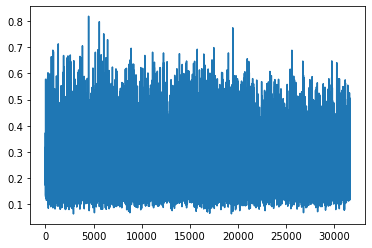

In [86]:
# 결과 출력
plt.plot(HI_data)

In [313]:
ave = []
m = 3000
for i in range(len(HI_data)):
    ave.append(HI_data[i:m+i].mean())

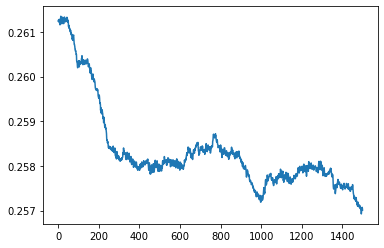

In [365]:
# 기어/베어링의 건강상태 그래프
plt.plot(ave[25500:27000])

In [382]:
# RUL 그래프 라벨링 데이터 생성
max_time = 100000
X_data_len = 16000-13000 + 27000 - 25500
#y_data = [i for i in range(0.0, X_data_len/(max_time*60*60), 1/(max_time*60*60))]
y_data_temp = np.arange(1, 0 , -1/(max_time)/30)
temp = []
for i in range(len(y_data_temp)):   
    temp.append(y_data_temp[i])
y_data = temp[2200000:X_data_len+2200000]

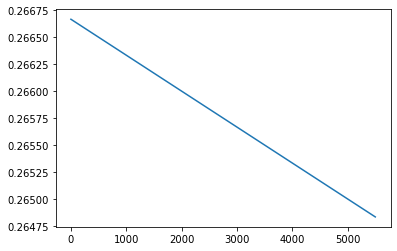

In [340]:
# 확인용 그래프 출력
plt.plot(y_data)

In [383]:
mid = 16000
last = 27000
rul_X_train = np.array(ave[13000:mid], np.float32)
rul_X_test = np.array(ave[25500:last], np.float32)
rul_y_train = np.array(y_data[0:mid-13000], np.float32)
rul_y_test = np.array(y_data[mid-13000:], np.float32)

In [384]:
len(rul_y_train)

3000

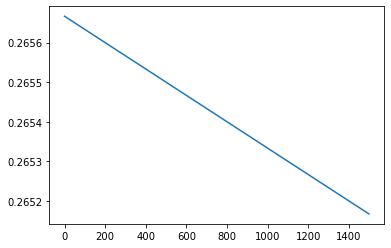

In [385]:
plt.plot(rul_y_test)

In [386]:
# RUL 예측을 위한 선형 모델 생성
rul_model = tf.keras.Sequential()

In [387]:
# 모델 층 구성
rul_model.add(tf.keras.layers.Dense(64, input_dim=1, activation="relu"))
rul_model.add(tf.keras.layers.Dense(1, input_dim=1))

In [388]:
# 모델 컴파일
rul_model.compile(optimizer="rmsprop", loss="mse", metrics=['accuracy'])

In [389]:
# 학습
hist = rul_model.fit(rul_X_train, rul_y_train, epochs=100, batch_size=128)

Train on 3000 samples
Epoch 1/100
3000/3000 [==============================] - 0s 81us/sample - loss: 0.0352 - accuracy: 0.0000e+00
Epoch 2/100
3000/3000 [==============================] - 0s 9us/sample - loss: 0.0032 - accuracy: 0.0000e+00
Epoch 3/100
3000/3000 [==============================] - 0s 9us/sample - loss: 2.8926e-05 - accuracy: 0.0000e+00
Epoch 4/100
3000/3000 [==============================] - 0s 9us/sample - loss: 1.5462e-07 - accuracy: 0.0000e+00
Epoch 5/100
3000/3000 [==============================] - 0s 8us/sample - loss: 7.4631e-06 - accuracy: 0.0000e+00
Epoch 6/100
3000/3000 [==============================] - 0s 8us/sample - loss: 1.0427e-05 - accuracy: 0.0000e+00
Epoch 7/100
3000/3000 [==============================] - 0s 7us/sample - loss: 9.9651e-06 - accuracy: 0.0000e+00
Epoch 8/100
3000/3000 [==============================] - 0s 7us/sample - loss: 1.0291e-05 - accuracy: 0.0000e+00
Epoch 9/100
3000/3000 [==============================] - 0s 8us/sample - loss: 1.

In [390]:
# 예측 데이터 저장
y_hat_rul = rul_model.predict(rul_X_test)

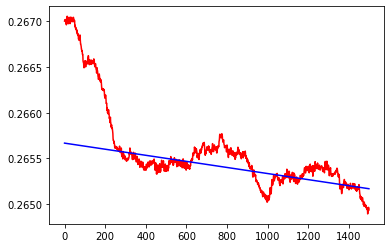

In [393]:
# 그래프를 통한 각 결과 비교
#plt.axis([0, 50, 0, 1])
plt.plot(y_hat_rul-0.003, "r-")
plt.plot(rul_y_test, "b-")
plt.show()

In [394]:
# 모델을 이용하여 예측 데이터 부풀리기
list_hat_rul =  [y_hat_rul[-1]-0.003]
for i in range(1000):
    list_hat_rul = np.append(list_hat_rul, rul_model.predict(list_hat_rul[-1:])-0.003)

In [395]:
list_hat_rul

array([0.26493353, 0.26868552, 0.2699882 , ..., 0.27066123, 0.2706612 ,
       0.27066123], dtype=float32)

In [396]:
# 기존 데이터와 합치기
RUL_data = np.concatenate((np.ravel(y_hat_rul, order="C"), list_hat_rul))

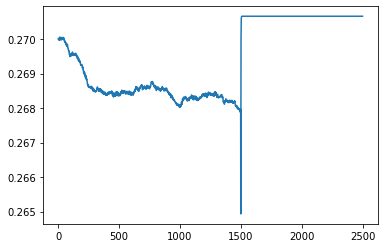

In [397]:
plt.plot(RUL_data)